### Based on this paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [4]:
from unicodedata import name
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [149]:
names = open("names.txt", "r").read().splitlines()

In [6]:
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [155]:
def build_dataset(names):
    block_size = 3 #context length of how many chars we take to predict the next char
    X, Y = [],[]
    
    for w in names:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # rolling window, makes sense when you run it
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

25626.4

In [162]:
import random
random.seed(42)
random.shuffle(names)
X_train, Y_train = build_dataset(names[:int(0.8*len(names))]) #get first 80% of the dataset
X_valid, Y_valid = build_dataset(names[int(0.8*len(names)):int(0.9*len(names))]) # get between 80%-90%
X_test, Y_test = build_dataset(names[int(0.9*len(names)):]) # get last 10% of dataset

In [165]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([182580, 3]), torch.Size([22767, 3]), torch.Size([22799, 3]))

### Build the embedding look up table C <br />
in the paper, they embed 17,000 words into 30 dimension vectors. We can do something similar, but with our 27 possible chars, we can go smaller; like 2 dimensional maybe?

In [10]:
C = torch.randn((27,2)) # has an embedding 2d vector for each of 27 chars we track

In [11]:
    #How does C[X] work?
# X is a 32,3 matrix, consisting of 32 inputs, with 3 context chars each.
# C is an embedding matrix, that has 27 rows, 1 for each token/char, and its corresponding embedding (2d vector)
# If X[0] is [0, 1, 2] (meaning the first 3 chars of context), then C[X[0]] would be a tensor formed by stacking the
# 0th, 1st, and 2nd rows of C on top of each other, resulting in a 3x2 matrix. This takes out the correct embeddings for each character,
# in each 3-char long context, across all input data X. When this operation is applied to all contexts in X, you get a tensor of shape
# [32, 3, 2] (assuming you have 32 such contexts generated), where 32 is the total number of such extracted contexts, 3 is the block_size,
# and 2 is the dimensionality of each embedding.

C[X_train].shape # cool pytorch indexing

torch.Size([32, 3, 2])

In [18]:
# this and the bottom cell are equivalent because C[X] plucks out embeddings (rows) for each of X's elements,
# and since the 14th element in X is 1, it directly plucks out C[1]
C[X_train][13,2], X[13]

(tensor([-0.8946,  0.7617]), tensor([0, 0, 1]))

In [19]:
C[1]

tensor([-0.8946,  0.7617])

In [20]:
# final product = embedding for each of 32 contexts (examples), and for each of their [3] chars
emb = C[X]
emb.shape 

torch.Size([32, 3, 2])

In [21]:
W1 = torch.randn((6,100)) # first set of weights (6 weights / neuron) * 100 neurons. 6 -> one context, 3chars*2d-vectors
b1 = torch.randn(100) # one bias for each neuron. Broadcasted

In [25]:
# now, we need to somehow connect the 3chars*2d-vectors = 6 numbers in order to pass through this layer. Broadcasting
# won't help us with our current dimensions
# view() is a very efficient way to change some internal parameters of how our tensor is tracked (shaped) in internal storage
# modifies shapes, strides and storage offset(?). All tensors are in reality long 1d arrays. shows that with tensor .storage()

emb = emb.view(-1,6)

In [51]:
# this is our first layer of activations.
h = torch.tanh(emb @ W1 + b1)
h.shape

torch.Size([32, 100])

In [36]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [42]:
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdims=True)
probs.shape

torch.Size([32, 27])

In [45]:
loss = -probs[torch.arange(32), Y].log().mean() #nll again
loss

tensor(17.9395)

In [46]:
# make the final steps nice again

In [234]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g) 
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g) 
b2 = torch.randn(27, generator=g)
params = [C, W1, b1, W2, b2]

In [235]:
sum(p.numel() for p in params) # number of parameters. About 15 openaitillion from sota

11897

In [236]:
# Forward pass
emb = C[X_train]
emb_cols = W1.shape[0]
h = torch.tanh(emb.view(-1,emb_cols) @ W1 + b1)
logits = h @ W2 + b2 # output from our network
counts = logits.exp() # 1st repetitive step. For this step, also, pytorch subtracts the largest number so when those nums get exponentiated
# there is no numerical overflow ( -> NaaN / infinity )
probs = counts / counts.sum(dim=1, keepdims=True) # 2nd repetitive step
loss = -probs[torch.arange(probs.shape[0]), Y_train].log().mean() # 3rd repetitive step
# don't need to keep doing this, as nn.functional.cross_entropy exists

print(F.cross_entropy(logits, Y_train)) # much more efficient. Pytorch does not create all those intermediate tensors. Has fused kernels(?)
# these are "computational kernels", designed to perform data processing stuff very efficiently. Usually cuda or c++ code that executes
# operations on GPUs in parallel. Convs, matmuls, reshapes probably as well. GPU's can run a kernel in each cell, of which there are
# thousands. When I call torch.matmul, under the hood, it dispatches a kernel on the GPU that handles the matrix multiplication.
# So it's like a function that is very fast.

# fused kernels combine several operations into one kernel to optimize performance. Instead of executing multiple sequential kernels
# where each performs one operation and passes its result to the next, a fused kernel performs all these operations in a single go
loss

tensor(26.0094)


tensor(26.0094)

In [237]:
for p in params:
    p.requires_grad=True

In [238]:
# let's also include grid search for our learning rate
# want to take many lr's in range from [0.001,1]
#lre = torch.linspace(-3,0,1000) # learning rate exponents. Doesn't really make sense to step between them linearly so we use exponents
#lrs = 10**lre #learning # learning rates
#lri = [] # keep track of learning rates in each iter
lossi = []
stepi = []

In [247]:
for i in range(50000):
    #forward pass
    ix = torch.randint(0,X_train.shape[0],(32,))
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1,emb_cols) @ W1 + b1)
    logits = h @ W2 + b2 # output from our network
    loss = F.cross_entropy(logits, Y_train[ix])
    
    # backward pass
    # zero out all gradients
    for p in params:
        p.grad = None # same as setting to 0
    loss.backward()
    lr = 0.01 #decayed it to 0.001 from 0.1 after 3 iters of this. Loss: 2.5 -> 2.6 -> 2.2 -> 1.86
    for p in params:
        p.data += -lr*p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
# since we have over 3k params, and for this specific training run only run 32 examples, model very easily overfits and gives low loss
# it actually takes too long to perform foward and backward pass on all input data we have. so let's do it in batches

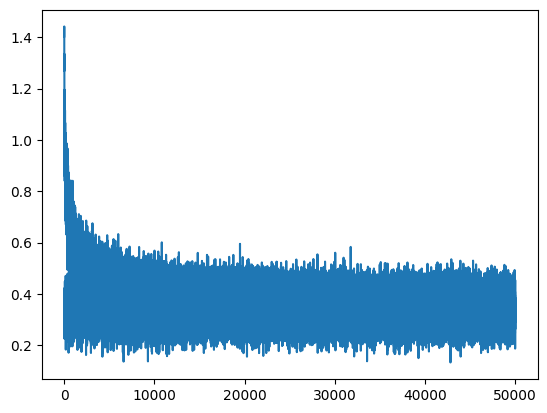

In [248]:
# plot the different learning rates
plt.plot(stepi, lossi)

In [249]:
# eval loss on full training data set after training
#ix = torch.randint(0,X.shape[0],(32,))
emb = C[X_train]
h = torch.tanh(emb.view(-1,emb_cols) @ W1 + b1)
logits = h @ W2 + b2 # output from our network
loss = F.cross_entropy(logits, Y_train)
print(loss)

tensor(2.1571, grad_fn=<NllLossBackward0>)


In [250]:
# eval loss on full validation data set after training
#ix = torch.randint(0,X.shape[0],(32,))
emb = C[X_valid]
h = torch.tanh(emb.view(-1,emb_cols) @ W1 + b1)
logits = h @ W2 + b2 # output from our network
loss = F.cross_entropy(logits, Y_valid)
print(loss)

tensor(2.1861, grad_fn=<NllLossBackward0>)


In [251]:
# loss might seem low, but we trained it on all data we have, including our non-existent test set.
# let's separate the data: train,valid,test
#                            80%, 10%, 10%. Did that now.
# let's now increase the size of the neural net because it doesn't even really seem to be overfitting at all.
#    Train loss: 2.25, Valid loss: 2.26

# even with increasing number of neurons from 100 to 300, our neural net seems bottlenecked
# it could be that our 2d embedding vectors are too small and the net can't model our characters effectively

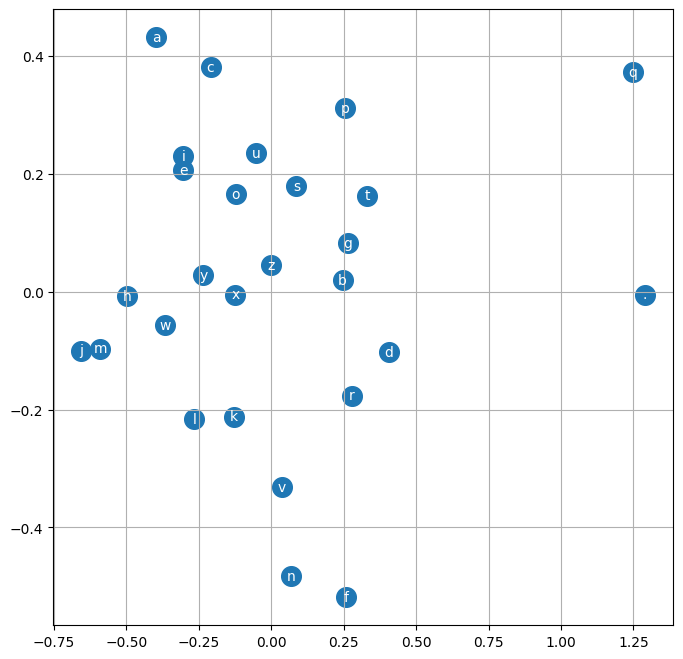

In [252]:
# visualizing our embeddings that were trained by our neural net
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [253]:
# still doesn't seem to be great. Can keep changing the size of the neural net and tuning the optimization
# of the dimensional of the embedding look up table C, the learning rate and its decay, the batchsize, blablabla...
# or we can start modelling and keeping track of more than 3 characters

In [256]:
# To end this off, let's sample from the model
g = torch.Generator().manual_seed(2147483647+10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # before it was (size of X, embedding vector dimension), but now we just need 1 example
        h = torch.tanh(emb.view(-1,30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1) # same as before, exponentiates, makes them sum to 1
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix] # sliding window again
        out.append(ix)
        if(ix == 0):
            break
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khiwmre.
revty.
halaysleer.
hutt.
deviah.
jareei.
nellara.
chaiivan.
legy.
dham.
pory.
quintzonovera.
jambi.
wazell.
dearynix.
kaelyighan.
edye.
iia.


In [ ]:
# next...